In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from fractal_noise import get_fractal_noise

0.4912547279903367
0.5
[                                                  ]
[
--------------------------------------------------]


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


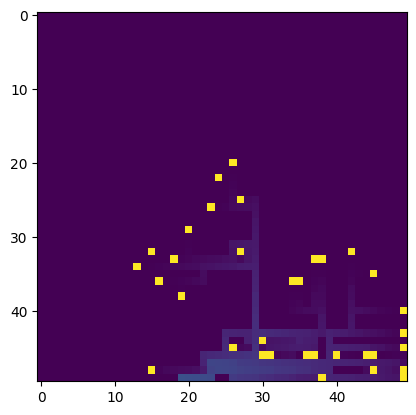

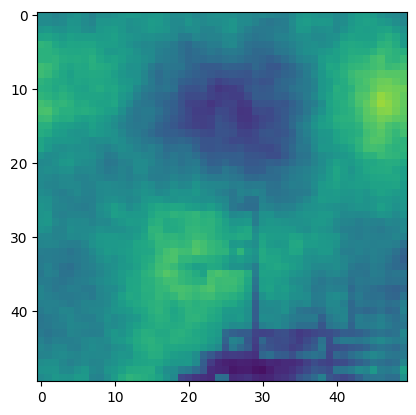

In [14]:
dir_to_vector = {
    1: np.array([0, 1]),    # up
    2: np.array([1, 0]),    # right
    3: np.array([0, -1]),   # down
    0: np.array([-1, 0])    # left
}

lr = {
    "UP": 0,
    "RIGHT": 1,
    "DOWN": 2,
    "LEFT": 3
}

def normalize(value, prev_lower, prev_upper, lower, upper):
    return (value - prev_lower) / (prev_upper - prev_lower) * (upper - lower) + lower

class Fungus:
    def __init__(self, greed=0.01):
        self.fungus = 0
        self.greed = greed
        self.connections = set()

    def update(self, grid, x, y):
        diff = self.greed if grid[x, y].substrate > self.greed else grid[x, y].substrate
        grid[x, y].substrate -= diff
        grid[x, y].content.fungus += diff
        if(grid[x, y].substrate < 0):
            grid[x, y].substrate = 0
        if(self.fungus > 1):
            self.fungus = 1


class Hyphae():
    def __init__(
            self,
            forward_probability=0.5,
            side_probability=0.25,
            greed=0.01,
            move_probab_lower = 0.8,
            creation_cost = 0.01,
            direction=0
    ):
        self.forward_probability = forward_probability
        self.side_probability = side_probability
        self.greed = greed
        self.move_probab_lower = move_probab_lower
        self.creation_cost = creation_cost
        self.direction = direction

    def to_global(self, direction):
        return (self.direction + direction) % 4

    def update(self, grid, x, y):
        movements = [
            (np.random.rand() <  self.forward_probability * normalize(grid[x,y].substrate, 0, 1, self.move_probab_lower, 1), lr["UP"]),   # relative forward
            (np.random.rand() < self.side_probability * normalize(grid[x,y].substrate, 0, 1, self.move_probab_lower, 1), lr["LEFT"]),       # relative left
            (np.random.rand() < self.side_probability * normalize(grid[x,y].substrate, 0, 1, self.move_probab_lower, 1), lr["RIGHT"])       # relative right
        ]
        # print(
        #     self.side_probability, " - ",
        #     self.move_probab_lower, " - ",
        #     grid[x,y].substrate, " - ",
        #     normalize(grid[x,y].substrate, 0, 1, self.move_probab_lower, 1), " - ",
        #     self.side_probability * normalize(grid[x,y].substrate, 0, 1, self.move_probab_lower, 1), " - ",
        #     movements
        # )

        has_moved = False
        dirs = []
        for m in movements:
            if m[0]:
                m_direction = self.to_global(m[1])
                dirs.append(m_direction)
                pos = np.array([x, y]) + dir_to_vector[m_direction]
                if(pos[0] < 0 or pos[0] >= grid.shape[0] or pos[1] < 0 or pos[1] >= grid.shape[1]):
                    # print(".", end="")
                    pass
                elif grid[pos[0], pos[1]].content is None:
                    grid[pos[0], pos[1]].content = Hyphae(
                        self.forward_probability,
                        self.side_probability,
                        self.greed,
                        self.move_probab_lower,
                        self.creation_cost,
                        m_direction
                    )
                    has_moved = True
        if has_moved:
            fungus = Fungus(self.greed)
            for d in dirs:
                fungus.connections.add(d)
            grid[x, y].content = fungus
            grid[x, y].substrate -= len(dirs) * self.creation_cost
            grid[x, y].substrate = 0 if grid[x, y].substrate < 0 else grid[x, y].substrate
        # else:
        #     print("no movement")





class Cell:
    def __init__(self, substrate):
        self.substrate = substrate
        self.content = None

    def update(self, grid, x, y):
        if self.content is not None:
            self.content.update(grid, x, y)



class Grid:
    def __init__(
            self, 
            size=100,
            hyphaes = [
                Hyphae()
            ],
            substrate_mean = 0.5,
            translocation_cost = 0.01
        ):
        self.translocation_cost = translocation_cost


        noise = get_fractal_noise(size, size, 0.5, [1, 1, 10])
        noise = normalize(noise, np.min(noise), np.max(noise), 0, 1)
        print(np.mean(noise))
        noise *= substrate_mean / (np.mean(noise))
        print(np.mean(noise))

        self.grid = np.array([[Cell(noise[i, j]) for j in range(size)] for i in range(size)])
        for h in hyphaes:
            x = np.random.randint(0, size)
            y = np.random.randint(0, size)
            self.grid[x, y].content = h

        self.fungus_images = []
        self.substrate_images = []

    def fungus_to_image(self):
        image = np.zeros(self.grid.shape)
        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1]):
                c = self.grid[i, j].content
                image[i, j] = 0 if c is None else c.fungus if isinstance(c, Fungus) else 2
        return image
    
    def substrate_to_image(self):
        image = np.zeros(self.grid.shape)
        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1]):
                image[i, j] = self.grid[i, j].substrate
        return image
    
    def substrate_movement(self, new_grid, multiplier=0.01):
        for i in range(self.grid.shape[0] - 1):
            for j in range(self.grid.shape[1]):
                diff = multiplier * (self.grid[i, j].substrate - self.grid[i+1, j].substrate)
                new_grid[i, j].substrate -= diff
                new_grid[i+1, j].substrate += diff

                ij_c = self.grid[i, j].content
                ip1j_c = self.grid[i+1, j].content
                if isinstance(ij_c, Fungus) \
                        and isinstance(ip1j_c, Fungus) \
                        and lr["RIGHT"] in ij_c.connections \
                        and lr["LEFT"] in ip1j_c.connections:
                    diff = multiplier * (self.grid[i, j].content.fungus - self.grid[i+1, j].content.fungus)
                    new_grid[i, j].content.fungus -= diff
                    new_grid[i+1, j].content.fungus += diff * (1 - self.translocation_cost)

        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1] - 1):
                diff = multiplier * (self.grid[i, j].substrate - self.grid[i, j+1].substrate)
                new_grid[i, j].substrate -= diff
                new_grid[i, j+1].substrate += diff * 0.9
                
                ij_c = self.grid[i, j].content
                ijp1_c = self.grid[i, j+1].content
                if isinstance(ij_c, Fungus) \
                        and isinstance(ijp1_c, Fungus) \
                        and lr["DOWN"] in ij_c.connections \
                        and lr["UP"] in ijp1_c.connections:
                    diff = multiplier * (self.grid[i, j].content.fungus - self.grid[i, j+1].content.fungus)
                    new_grid[i, j].content.fungus -= diff
                    new_grid[i, j+1].content.fungus += diff

    def run(self, steps=20):
        print("[" + (" " * min(steps, 100)) + "]")
        print("[", end="")
        self.fungus_images.append(self.fungus_to_image())
        self.substrate_images.append(self.substrate_to_image())

        for s in range(steps):
            if(s % 100 == 0):
                print("")
            print("-", end="")
            new_grid = copy.deepcopy(self.grid)
            self.grid = self.substrate_movement(new_grid)
            
            self.grid = new_grid
            new_grid = copy.deepcopy(self.grid)


            for i in range(self.grid.shape[0]):
                for j in range(self.grid.shape[1]):
                    self.grid[i, j].update(new_grid, i, j)
            
            self.grid = new_grid
            self.fungus_images.append(self.fungus_to_image())
            self.substrate_images.append(self.substrate_to_image())
        print("]")

    def animate(self, images, interval ,fileName):
        fig, ax = plt.subplots()
        ims = []
        max_value = max([np.max(image) for image in images])
        min_value = min([np.min(image) for image in images])
        for image in images:
            im = ax.imshow(image, animated=True, vmin=0, vmax=max_value)
            ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True, repeat_delay=1000, repeat=True)
        ani.save(f'{fileName}.gif', writer='imagemagick')

    def generate_gifs(self, interval=50, gap=1):
        self.animate(self.fungus_images[::gap], interval, "fungus")
        self.animate(self.substrate_images[::gap], interval, "substrate")

        


    


grid = Grid(50, [Hyphae(forward_probability=0.8, side_probability=0.1, direction=1)])
grid.run(50)
grid.generate_gifs()

In [4]:
grid.run(250)
grid.generate_gifs()

[                                                                                                    ]
[
-----------------------

KeyboardInterrupt: 